In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib as mpl
import seaborn
mpl.rcParams['figure.figsize']=(15.0,8.0)    
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
from matplotlib import pyplot as plt

import stingray as sr

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, Crossspectrum, AveragedCrossspectrum
from stingray import events
from stingray.events import EventList
import glob
import numpy as np
from astropy.modeling import models, fitting


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# R.m.s. - intensity diagram

This diagram is used to characterize the variability of black hole binaries and AGN (see e.g. Plant et al., arXiv:1404.7498; McHardy 2010 2010LNP...794..203M for a review).

In Stingray it is very easy to calculate.

## Setup: simulate a light curve with a variable rms and rate
We simulate a light curve with powerlaw variability, and then we rescale
it so that it has increasing flux and r.m.s. variability.

In [3]:
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d
from stingray.utils import baseline_als
from scipy.interpolate import interp1d


np.random.seed(1034232)
# Simulate a light curve with increasing variability and flux
length = 10000
dt = 0.1
times = np.arange(0, length, dt)

# Create a light curve with powerlaw variability (index 1), 
# and smooth it to eliminate some Gaussian noise. We will simulate proper
# noise with the `np.random.poisson` function.
# Both should not be used together, because they alter the noise properties.
sim = Simulator(dt=dt, N=int(length/dt), mean=50, rms=0.4)
counts_cont = sim.simulate(1).counts
counts_cont_init = gaussian_filter1d(counts_cont, 200)

C:\Users\tarui\AppData\Local\Temp\ipykernel_20128\1939614034.py:2: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
C:\Users\tarui\OneDrive\Desktop\Stingray\stingray\stingray\utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
C:\Users\tarui\OneDrive\Desktop\Stingray\stingray\stingray\lightcurve.py:328: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


In [4]:
# ---------------------
# Renormalize so that the light curve has increasing flux and r.m.s. 
# variability.
# ---------------------


# The baseline function cannot be used with too large arrays. 
# Since it's just an approximation, we will just use one every
# ten array elements to calculate the baseline
mask = np.zeros_like(times, dtype=bool)
mask[::10] = True
print (counts_cont_init[mask])

baseline = baseline_als(times[mask], counts_cont_init[mask], 1e10, 0.001)
base_func = interp1d(times[mask], baseline, bounds_error=False, fill_value='extrapolate')

counts_cont = counts_cont_init - base_func(times)

counts_cont -= np.min(counts_cont)
counts_cont += 1
counts_cont *= times * 0.003
# counts_cont += 500
counts_cont += 500


[64.19501839 64.19739588 64.20445924 ... 52.81710861 52.82594646
 52.83117218]


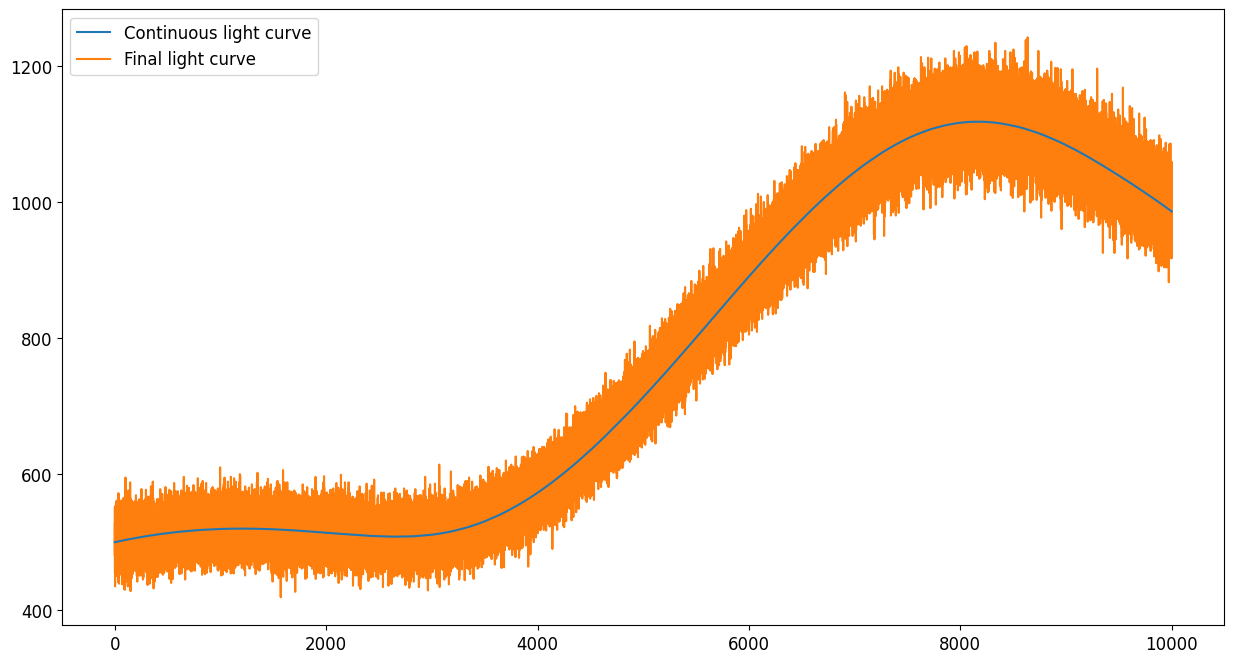

In [5]:
# Finally, Poissonize it!
counts = np.random.poisson(counts_cont)
plt.plot(times, counts_cont, zorder=10, label='Continuous light curve')
plt.plot(times, counts, label='Final light curve')

plt.legend()


## R.m.s. - intensity diagram

We use the `analyze_lc_chunks` method in `Lightcurve` to calculate two quantities: the rate and the excess variance, normalized as $F_{\rm var}$ (Vaughan et al. 2010).
`analyze_lc_chunks()` requires an input function that just accepts a light curve. Therefore, we create the two functions `rate` and `excvar` that wrap the existing functionality in Stingray.

Then, we plot the results.

Done!

In [6]:
# This function can be found in stingray.utils
def excess_variance(lc, normalization='fvar'):
    """Calculate the excess variance.

    Vaughan et al. 2003, MNRAS 345, 1271 give three measurements of source
    intrinsic variance: the *excess variance*, defined as
    
    .. math:: \sigma_{XS} = S^2 - \overline{\sigma_{err}^2}
    
    the *normalized excess variance*, defined as
    
    .. math:: \sigma_{NXS} = \sigma_{XS} / \overline{x^2}
    
    and the *fractional mean square variability amplitude*, or 
    :math:`F_{var}`, defined as
    
    .. math:: F_{var} = \sqrt{\dfrac{\sigma_{XS}}{\overline{x^2}}}
    

    Parameters
    ----------
    lc : a :class:`Lightcurve` object
    normalization : str
        if 'fvar', return the fractional mean square variability :math:`F_{var}`. 
        If 'none', return the unnormalized excess variance variance 
        :math:`\sigma_{XS}`. If 'norm_xs', return the normalized excess variance
        :math:`\sigma_{XS}`

    Returns
    -------
    var_xs : float
    var_xs_err : float
    """
    lc_mean_var = np.mean(lc.counts_err ** 2)
    lc_actual_var = np.var(lc.counts)
    var_xs = lc_actual_var - lc_mean_var
    mean_lc = np.mean(lc.counts)
    mean_ctvar = mean_lc ** 2
    var_nxs = var_xs / mean_lc ** 2

    fvar = np.sqrt(var_xs / mean_ctvar)

    N = len(lc.counts)
    var_nxs_err_A = np.sqrt(2 / N) * lc_mean_var / mean_lc ** 2
    var_nxs_err_B = np.sqrt(mean_lc ** 2 / N) * 2 * fvar / mean_lc
    var_nxs_err = np.sqrt(var_nxs_err_A ** 2 + var_nxs_err_B ** 2)

    fvar_err = var_nxs_err / (2 * fvar)

    if normalization == 'fvar':
        return fvar, fvar_err
    elif normalization == 'norm_xs':
        return var_nxs, var_nxs_err
    elif normalization == 'none' or normalization is None:
        return var_xs, var_nxs_err * mean_lc **2

2024-02-15 17:36:24,354 - stingray.loggingconfig - INFO - Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation. (lightcurve.py:486)
2024-02-15 17:36:24,617 - stingray.loggingconfig - INFO - Checking if light curve is sorted. (lightcurve.py:521)
C:\Users\tarui\OneDrive\Desktop\Stingray\stingray\stingray\lightcurve.py:328: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
C:\Users\tarui\AppData\Local\Temp\ipykernel_20128\2137497220.py:41: RuntimeWarning: invalid value encountered in sqrt
  fvar = np.sqrt(var_xs / mean_ctvar)


Text(0, 0.5, '$F_{\\rm var}$')

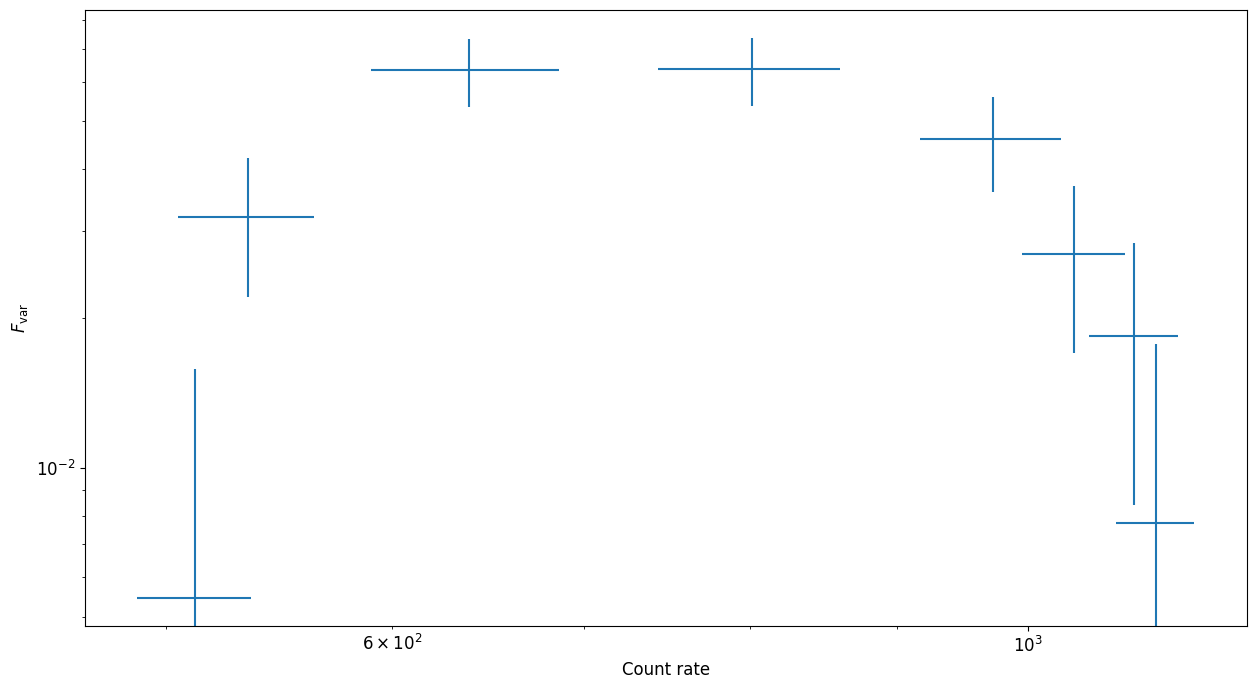

In [7]:
def fvar_fun(lc):
    return excess_variance(lc, normalization='fvar')

def norm_exc_var_fun(lc):
    return excess_variance(lc, normalization='norm_xs')

def exc_var_fun(lc):
    return excess_variance(lc, normalization='none')

def rate_fun(lc):
    return lc.meancounts, np.std(lc.counts)

lc = Lightcurve(times, counts, gti=[[-0.5*dt, length - 0.5*dt]], dt=dt)

start, stop, res = lc.analyze_lc_chunks(1000, np.var)
var = res

start, stop, res = lc.analyze_lc_chunks(1000, rate_fun)
rate, rate_err = res

start, stop, res = lc.analyze_lc_chunks(1000, fvar_fun)
fvar, fvar_err = res

start, stop, res = lc.analyze_lc_chunks(1000, exc_var_fun)
evar, evar_err = res

start, stop, res = lc.analyze_lc_chunks(1000, norm_exc_var_fun)
nvar, nvar_err = res

plt.errorbar(rate, fvar, xerr=rate_err, yerr=fvar_err, fmt='none')
plt.loglog()
plt.xlabel('Count rate')
plt.ylabel(r'$F_{\rm var}$')

In [10]:
tmean = (start + stop)/2

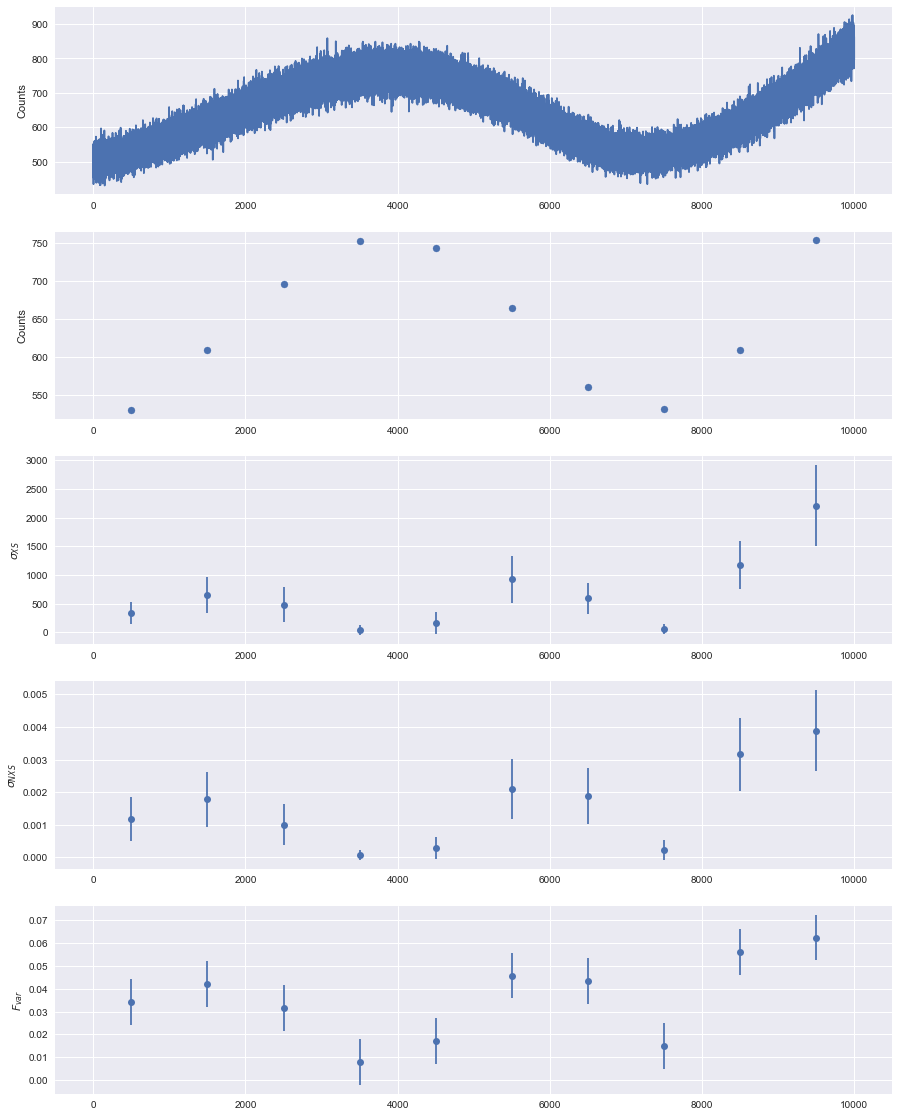

In [11]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(15, 20))
gs = GridSpec(5, 1)
ax_lc = plt.subplot(gs[0])
ax_mean = plt.subplot(gs[1], sharex=ax_lc)
ax_evar = plt.subplot(gs[2], sharex=ax_lc)
ax_nvar = plt.subplot(gs[3], sharex=ax_lc)
ax_fvar = plt.subplot(gs[4], sharex=ax_lc)

ax_lc.plot(lc.time, lc.counts)
ax_lc.set_ylabel('Counts')
ax_mean.scatter(tmean, rate)
ax_mean.set_ylabel('Counts')

ax_evar.errorbar(tmean, evar, yerr=evar_err, fmt='o')
ax_evar.set_ylabel(r'$\sigma_{XS}$')

ax_fvar.errorbar(tmean, fvar, yerr=fvar_err, fmt='o')
ax_fvar.set_ylabel(r'$F_{var}$')

ax_nvar.errorbar(tmean, nvar, yerr=nvar_err, fmt='o')
ax_nvar.set_ylabel(r'$\sigma_{NXS}$')

